In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

from zipfile import *

file_name = '/content/gdrive/My Drive/datasets/exp-data.zip'
with ZipFile(file_name, 'r') as f:
  f.extractall()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import Activation, BatchNormalization
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from keras.models import load_model

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PATH = 'dataset/exp-data'
PATH = '/content/exp-data'
STORE_NAME = 'dcgan_improved' # name of folders
store_image_dir = '{}_images'.format(STORE_NAME) # folder to store images for NN

# data variables
IMG_SIZE = 128
CHANNELS = 3
NOISE_DIM = 100

# create numpy array (tensor) for the dataset
train_images = np.ndarray(shape=(6000, IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, img in enumerate(os.listdir(PATH)):
    if i >= 6000:
        break
    # using keras image preprocessing package convert the images into a matrix
    image = load_img(PATH + '/' + img)
    x = img_to_array(image)
    
    # add the matrices into the tensor
    train_images[i] = x

train_images.shape

Using TensorFlow backend.


(6000, 128, 128, 3)

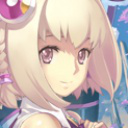

In [0]:
test = array_to_img(train_images[1])
test

In [0]:
train_images[1][0][0]

array([180.,  91., 149.], dtype=float32)

In [0]:
train_images = (train_images-127.5) / 127.5
train_images[1][0][0]

array([ 0.4117647 , -0.28627452,  0.16862746], dtype=float32)

## Hyperparameters

In [0]:
# training variables
EPOCHS = 300
BATCH_SIZE = 32

# hyperparameter tuning 
MOMENTUM = 0.8
ALPHA = 0.1
EPSILON = 0.00005
LEARNING_RATE=0.0002
BETA1 = 0.5

## Building a Generator

In [0]:
def Generator(inputs):
  X = Dense(8*8*1024, activation='relu')(inputs)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  X = Reshape((8,8,1024))(X)
  
  X = Conv2DTranspose(512, kernel_size=(5,5), strides=(2,2), padding='same')(X)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  
  X = Conv2DTranspose(256, kernel_size=(5,5) , strides=(2,2), padding='same')(X)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  
  X = Conv2DTranspose(128, kernel_size=(5,5), strides=(2,2), padding='same')(X)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  
  X = Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same')(X)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  
  X = Conv2D(3, kernel_size=(5,5), strides=(1,1), padding='same')(X)
  out = Activation('tanh')(X)
  
  return Model(inputs, out)

## Building a Discriminator

In [0]:
def Discriminator(inputs):
  X = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(inputs)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  
  X = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same')(X)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  
  X = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same')(X)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  
  X = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same')(X)
  X = BatchNormalization(momentum=MOMENTUM)(X)
  X = LeakyReLU(alpha=ALPHA)(X)
  
  X = Flatten()(X)
  X = Dropout(0.5)(X)
  out = Dense(1, activation='sigmoid')(X)
  
  return Model(inputs, out)

## Compiling Model

In [0]:
# inputs for generator and discriminator
noise = Input(shape=(NOISE_DIM,))
image_input = Input(shape=(128,128,3))

# creating generator and discriminator models
generator = Generator(noise)
discriminator = Discriminator(image_input)

# define optimizer
adam = Adam(lr=LEARNING_RATE, beta_1=BETA1)

# compile the discriminator
discriminator.compile(loss='binary_crossentropy', 
              optimizer=adam,
             metrics=['accuracy'])

# compile generator and discriminator
# training generator to fool discriminator
discriminator.trainable = False
fake_image = generator(noise)
fake_pred = discriminator(fake_image)
gan = Model(inputs=noise, outputs=fake_pred)
gan.compile(loss='binary_crossentropy', optimizer=adam)

generator.summary()
discriminator.summary()

W0619 15:48:50.090843 139832717666176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 15:48:50.108508 139832717666176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 15:48:50.113520 139832717666176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 15:48:50.196420 139832717666176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0619 15:48:50.262322 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
batch_normalization_1 (Batch (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 65536)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 512)       2048      
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## Training

In [0]:
try:
    os.makedirs(store_image_dir)
except FileExistsError:
    pass
  
try:
    os.makedirs('model')
except FileExistsError:
    pass

def show_samples(epoch, sample_images, dim=(4,4), figsize=(8,8)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(sample_images):
        img = ((img*127.5)+127.5)
        image = array_to_img(img)
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/epoch {}.png'.format(store_image_dir, epoch))
    plt.show()
    plt.close()

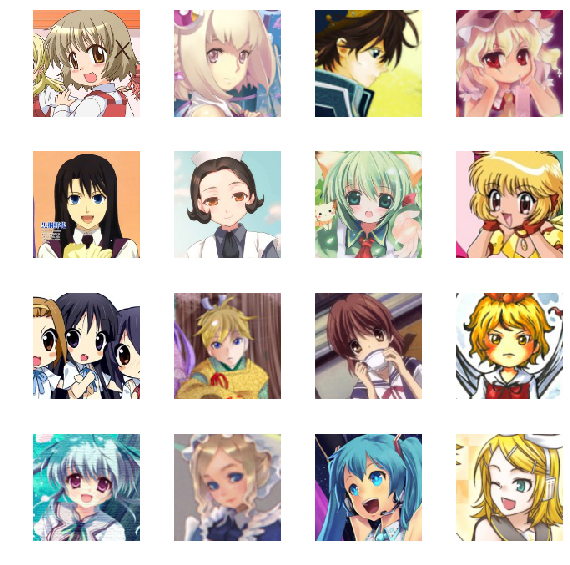

In [0]:
show_samples(0,train_images[:16])

In [0]:
dlosses=[]
glosses=[]

def train(epochs, batch_size=64,step=1):
  # training of (6000,128,128,3)
  m = train_images.shape[0] # number of training examples
  batch_count = m/batch_size # number of minibatches
  print ('Epochs:', epochs)
  print ('Batch size:', batch_size)
  print ('Batches per epoch:', batch_count)
    
  for e in range(step, epochs+1):
    accumulated_dlosses = 0
    accumulated_glosses = 0
    
    # minibatches without the end case
    for _ in tqdm(np.arange(batch_count)):
      # getting m training samples
      real_images = train_images[np.random.randint(0, train_images.shape[0], size=batch_size)]    
      # noise data for generation
      z_batch = np.random.normal(size=(batch_size, NOISE_DIM))

      # generating images from noise data
      generated_images = generator.predict(z_batch)

      # train on soft labels
      noise_prop = 0.05 # randomly flip 5% of labels
      
      discriminator.trainable = True
      # create label for real data (0.0-0.1)
      real_labels = np.zeros((batch_size, 1)) + np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))
      flipped_idx = np.random.choice(np.arange(len(real_labels)), size=int(noise_prop*len(real_labels)))
      real_labels[flipped_idx] = 1 - real_labels[flipped_idx]
      # train discriminator on real data
      dloss_real = discriminator.train_on_batch(real_images, real_labels)

      # create label for generated data (0.9-1.0)
      fake_labels = np.ones((batch_size, 1)) - np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))
      flipped_idx = np.random.choice(np.arange(len(fake_labels)), size=int(noise_prop*len(fake_labels)))
      fake_labels[flipped_idx] = 1 - fake_labels[flipped_idx]

      # train discriminator on generated data
      dloss_fake = discriminator.train_on_batch(generated_images, fake_labels)

      dloss = 0.5 * np.add(dloss_real[0],dloss_fake[0])
      accumulated_dlosses += dloss
      
      discriminator.trainable = False
      # train generator
      gloss = gan.train_on_batch(z_batch, np.zeros((batch_size, 1)))
      accumulated_glosses += gloss
      
    final_dloss = round(accumulated_dlosses/batch_count, 5)
    final_gloss = round(accumulated_glosses/batch_count, 5)
    
    print('Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(e, final_gloss, final_dloss))
    dlosses.append(final_gloss)
    glosses.append(final_dloss)

    if e == step or e % 5 == 0:
      z_batch = np.random.normal(size=(batch_size, NOISE_DIM))
      generated_images = generator.predict(z_batch)
      show_samples(e, generated_images[:16])

    if e % 25 == 0 and e is not step:
      print('Model saved for epoch {}'.format(e))
      discriminator.save('model/disc.h5'.format(e))
      gan.save('model/gan.h5'.format(e))
        

  0%|          | 0/188 [00:00<?, ?it/s]

Epochs: 300
Batch size: 32
Batches per epoch: 187.5


100%|██████████| 188/188 [02:38<00:00,  1.27it/s]


Epoch: 1, Generator Loss: 6.85933, Discriminator Loss: 0.85955


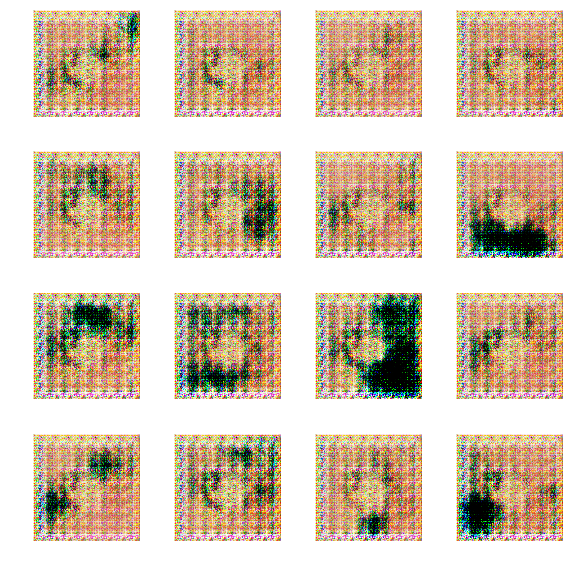

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 2, Generator Loss: 2.09501, Discriminator Loss: 0.6678


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 3, Generator Loss: 2.1498, Discriminator Loss: 0.61205


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 4, Generator Loss: 2.17384, Discriminator Loss: 0.601


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch: 5, Generator Loss: 1.81181, Discriminator Loss: 0.52326


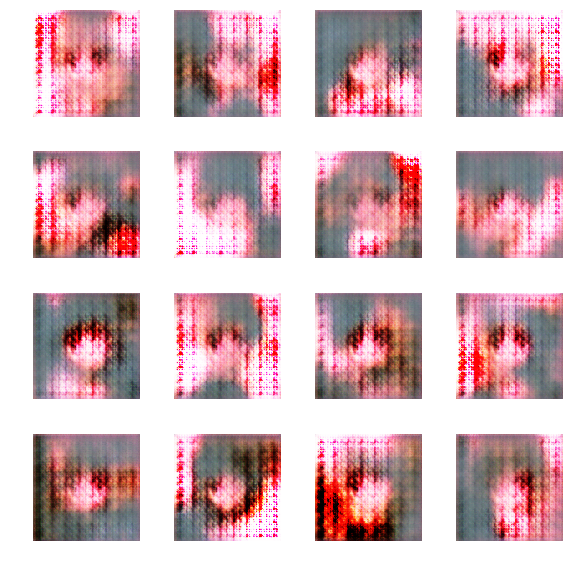

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 6, Generator Loss: 1.84336, Discriminator Loss: 0.55797


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 7, Generator Loss: 1.97998, Discriminator Loss: 0.53198


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 8, Generator Loss: 1.48637, Discriminator Loss: 0.48554


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 9, Generator Loss: 1.75944, Discriminator Loss: 0.49113


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch: 10, Generator Loss: 1.78239, Discriminator Loss: 0.45946


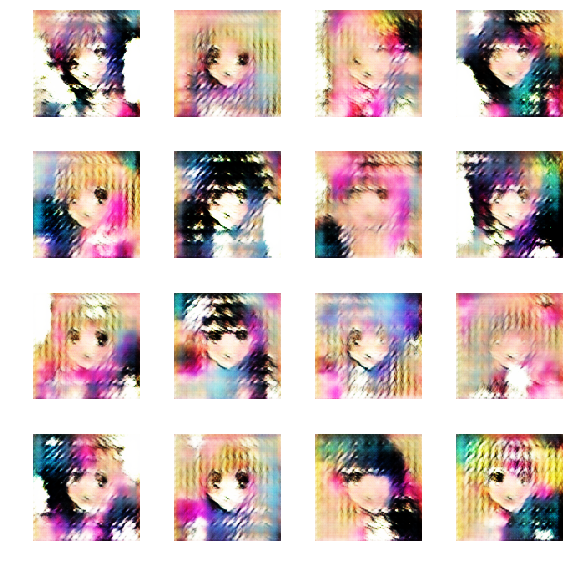

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 11, Generator Loss: 2.26103, Discriminator Loss: 0.49766


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 12, Generator Loss: 2.04893, Discriminator Loss: 0.45872


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 13, Generator Loss: 1.96682, Discriminator Loss: 0.45073


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 14, Generator Loss: 1.89119, Discriminator Loss: 0.44167


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch: 15, Generator Loss: 2.09, Discriminator Loss: 0.43382


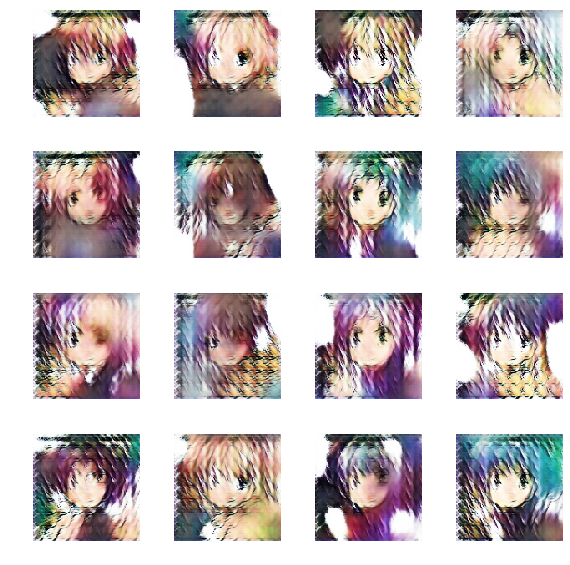

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 16, Generator Loss: 2.03233, Discriminator Loss: 0.43032


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 17, Generator Loss: 1.90932, Discriminator Loss: 0.41772


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 18, Generator Loss: 2.12643, Discriminator Loss: 0.40437


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 19, Generator Loss: 2.1785, Discriminator Loss: 0.41579


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch: 20, Generator Loss: 2.11073, Discriminator Loss: 0.41327


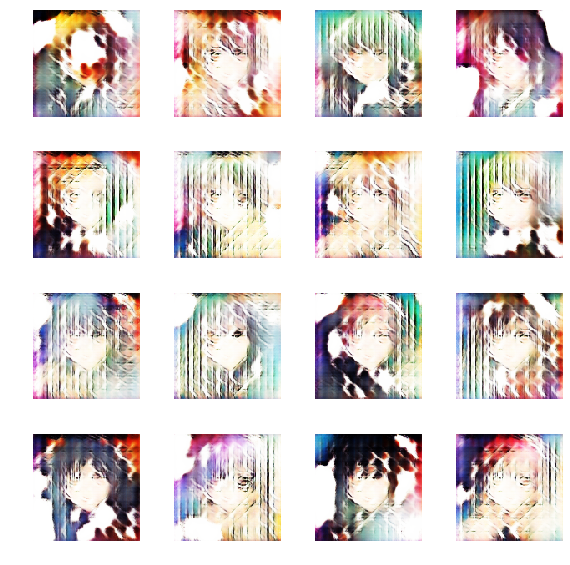

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 21, Generator Loss: 2.18138, Discriminator Loss: 0.4033


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 22, Generator Loss: 1.92526, Discriminator Loss: 0.38915


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 23, Generator Loss: 2.19793, Discriminator Loss: 0.40601


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 24, Generator Loss: 2.11095, Discriminator Loss: 0.4037


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch: 25, Generator Loss: 2.34571, Discriminator Loss: 0.39335


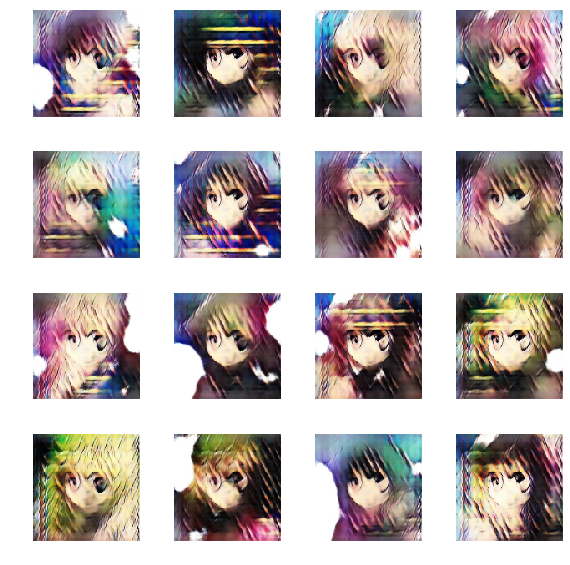

Model saved for epoch 25


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 26, Generator Loss: 2.18165, Discriminator Loss: 0.39264


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 27, Generator Loss: 2.01207, Discriminator Loss: 0.39379


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 28, Generator Loss: 2.20695, Discriminator Loss: 0.38933


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 29, Generator Loss: 1.97608, Discriminator Loss: 0.37353


100%|██████████| 188/188 [02:27<00:00,  1.27it/s]


Epoch: 30, Generator Loss: 2.44706, Discriminator Loss: 0.39655


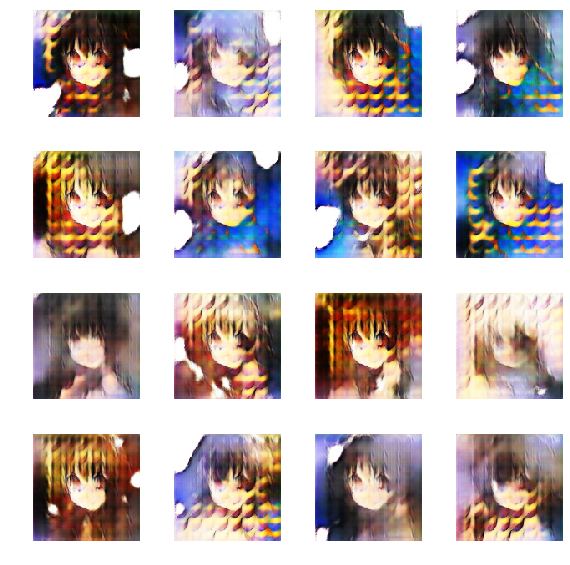

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 31, Generator Loss: 2.57233, Discriminator Loss: 0.39164


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 32, Generator Loss: 2.31727, Discriminator Loss: 0.40513


 65%|██████▌   | 123/188 [01:36<00:51,  1.27it/s]

KeyboardInterrupt: ignored

In [0]:
train(EPOCHS, batch_size=BATCH_SIZE)

In [0]:
plt.plot(glosses)
plt.plot(dlosses)
plt.show()

In [0]:
!zip -r /content/file.zip /content/dcgan_improved_images